# Coding: Machine Translation with Transformer

 - Dataset: wmt-17, en-zh, select 1m high-quality pairs of data
 - Model: Seq2seq with Transformer (Attention is all you need)
 - GPU: 4090

In [1]:
# Download the data & select 5m high-quality pairs

from datasets import load_dataset
import re

# load full wmt-17 en-zh dataset
full_dataset = load_dataset("wmt/wmt17", "zh-en", split="train")

# Length & Ratio filter
def is_high_quality(x):
    en = x["translation"]["en"]
    zh = x["translation"]["zh"]
    if not en or not zh:
        return False
    if len(en) < 3 or len(zh) < 3:
        return False
    if len(en) > 100 or len(zh) > 100:
        return False
    ratio = len(en) / len(zh)
    if ratio < 0.5 or ratio > 2:
        return False
    if not re.search(r'[\u4e00-\u9fff]', zh):
        return False
    return True

filtered_dataset = full_dataset.filter(is_high_quality, num_proc=10)

dataset = filtered_dataset.select(range(min(5_000_000, len(filtered_dataset))))

print("Full Dataset Size: ", len(full_dataset))
print("Filtered Dataset Size: ", len(filtered_dataset))
print("Dataset Size: ", len(dataset))

# print 10 samples
sample = dataset.shuffle(seed=42).select(range(10))
print("-"*100)
for i in sample:
    print(i["translation"]["en"])
    print(i["translation"]["zh"])
    print("-"*100)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00013.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

train-00001-of-00013.parquet:   0%|          | 0.00/272M [00:00<?, ?B/s]

train-00002-of-00013.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

train-00003-of-00013.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

train-00004-of-00013.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

train-00005-of-00013.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

train-00006-of-00013.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

train-00007-of-00013.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

train-00008-of-00013.parquet:   0%|          | 0.00/294M [00:00<?, ?B/s]

train-00009-of-00013.parquet:   0%|          | 0.00/272M [00:00<?, ?B/s]

train-00010-of-00013.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

train-00011-of-00013.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

train-00012-of-00013.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/394k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/362k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25134743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2001 [00:00<?, ? examples/s]

Filter (num_proc=10):   0%|          | 0/25134743 [00:00<?, ? examples/s]

Full Dataset Size:  25134743
Filtered Dataset Size:  1141860
Dataset Size:  1141860
----------------------------------------------------------------------------------------------------
Zambia (7)
赞比亚(7)
----------------------------------------------------------------------------------------------------
15:00 to 18:00 Informal consultations (closed) Conference Room 5 (NLB)
下午3:00－6:00 非正式磋商(闭门会议) 第5会议室(北草坪会议大楼)
----------------------------------------------------------------------------------------------------
Spain
西班牙
----------------------------------------------------------------------------------------------------
Mr. Robert Morrison
Robert Morrison先生 加拿大自然资源部
----------------------------------------------------------------------------------------------------
This satisfied the kids, but not the husband.
"孩子们得到了满意的答案, 但她的丈夫却没有。
----------------------------------------------------------------------------------------------------
Shutaro Omura (Japan)
Shutaro Omura（日本）
---------------

In [2]:
# Create PyTorch Dataset and DataLoader for training

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer_en, tokenizer_zh, max_length=100):
        """
        PyTorch Dataset wrapper for HuggingFace translation dataset
        
        Args:
            hf_dataset: HuggingFace dataset with translation pairs
            tokenizer_en: English tokenizer (optional, can be added later)
            tokenizer_zh: Chinese tokenizer (optional, can be added later)
            max_length: Maximum sequence length
        """
        self.dataset = hf_dataset
        self.tokenizer_en = tokenizer_en
        self.tokenizer_zh = tokenizer_zh
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        en_text = item["translation"]["en"]
        zh_text = item["translation"]["zh"]

        en_tokens = self.tokenizer_en(en_text, 
                                        max_length=self.max_length, 
                                        padding='max_length', 
                                        truncation=True, 
                                        return_tensors='pt')
            
        zh_tokens = self.tokenizer_zh(zh_text, 
                                        max_length=self.max_length, 
                                        padding='max_length', 
                                        truncation=True, 
                                        return_tensors='pt')
            
        return {
                'source_ids': en_tokens['input_ids'].squeeze(),
                'target_ids': zh_tokens['input_ids'].squeeze(),
                'source_text': en_text,
                'target_text': zh_text
        }

def create_dataloaders(dataset, batch_size=128, num_workers=12, train_split=0.95):
    """
    Create train and validation DataLoaders from HuggingFace dataset
    
    Args:
        dataset: HuggingFace dataset with translation pairs
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for data loading
        train_split: Fraction of data to use for training
    
    Returns:
        train_dataloader, val_dataloader, train_dataset, val_dataset
    """
    
    # Split dataset into train and validation
    train_size = int(train_split * len(dataset))
    
    # Create indices for splitting
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices, 
                                                train_size=train_size, 
                                                random_state=42)
    
    # Create train and validation datasets
    train_dataset_hf = dataset.select(train_indices)
    val_dataset_hf = dataset.select(val_indices)

    # tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

    # get vocab sizes
    vocab_size_en = tokenizer_en.vocab_size
    vocab_size_zh = tokenizer_zh.vocab_size

    print(f"Vocab size for en: {vocab_size_en}")
    print(f"Vocab size for zh: {vocab_size_zh}")

    # Create PyTorch datasets
    train_dataset = TranslationDataset(train_dataset_hf, tokenizer_en, tokenizer_zh)
    val_dataset = TranslationDataset(val_dataset_hf, tokenizer_en, tokenizer_zh)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Train DataLoader: {len(train_dataloader)} batches")
    print(f"Validation DataLoader: {len(val_dataloader)} batches")
    
    return train_dataloader, val_dataloader, vocab_size_en, vocab_size_zh

def test_dataloader(dataloader):
    """Test the DataLoader by printing a sample batch"""
    print("\n" + "="*50)
    print("Sample batch from DataLoader:")
    print("="*50)
    
    for batch in dataloader:
        print(f"Batch size: {len(batch['source_text'])}")
        print(f"Source example: {batch['source_text'][0]}")
        print(f"Source tokens: {batch['source_ids'][0]}")
        print(f"Target example: {batch['target_text'][0]}")
        print(f"Target tokens: {batch['target_ids'][0]}")
        break

train_dataloader, val_dataloader, encoder_vocab_size, decoder_vocab_size = create_dataloaders(dataset)
test_dataloader(train_dataloader)
test_dataloader(val_dataloader)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Vocab size for en: 30522
Vocab size for zh: 21128
Train dataset size: 1084767
Validation dataset size: 57093
Train DataLoader: 8475 batches
Validation DataLoader: 447 batches

Sample batch from DataLoader:
Batch size: 128
Source example: B. Biennium 2010-2011
Source tokens: tensor([  101,  1038,  1012, 29316, 14907,  2230,  1011,  2249,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

In [3]:
# Define the Transformer model for Machine Translation
# Following "Attention is All You Need" architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear transformations and reshape
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        # Final linear transformation
        output = self.W_o(attention_output)
        
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        # Self-attention with residual connection
        self_attn_output = self.self_attention(x, x, x, self_attn_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        
        # Cross-attention with residual connection
        cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x

class Transformer(nn.Module):
    def __init__(self, encoder_vocab_size, decoder_vocab_size, d_model=512, num_heads=8, 
                 num_encoder_layers=6, num_decoder_layers=6, d_ff=2048, dropout=0.1, max_len=100):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        
        # Embeddings
        self.encoder_embedding = nn.Embedding(encoder_vocab_size, d_model, padding_idx=0)
        self.decoder_embedding = nn.Embedding(decoder_vocab_size, d_model, padding_idx=0)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, decoder_vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        
        # Initialize parameters
        self._init_parameters()
    
    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def create_padding_mask(self, x, pad_idx=0):
        return (x != pad_idx).unsqueeze(1).unsqueeze(2)
    
    def create_look_ahead_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask == 0
    
    def encode(self, src, src_mask=None):
        # Embedding and positional encoding
        src_emb = self.encoder_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.positional_encoding(src_emb.transpose(0, 1)).transpose(0, 1)
        src_emb = self.dropout(src_emb)
        
        # Pass through encoder layers
        encoder_output = src_emb
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)
        
        return encoder_output
    
    def decode(self, tgt, encoder_output, tgt_mask=None, src_mask=None):
        # Embedding and positional encoding
        tgt_emb = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.positional_encoding(tgt_emb.transpose(0, 1)).transpose(0, 1)
        tgt_emb = self.dropout(tgt_emb)
        
        # Pass through decoder layers
        decoder_output = tgt_emb
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, tgt_mask, src_mask)
        
        return decoder_output
    
    def forward(self, src, tgt):
        # Create masks
        src_mask = self.create_padding_mask(src)
        tgt_mask = self.create_padding_mask(tgt) & self.create_look_ahead_mask(tgt.size(1)).to(tgt.device)
        
        # Encode
        encoder_output = self.encode(src, src_mask)
        
        # Decode
        decoder_output = self.decode(tgt, encoder_output, tgt_mask, src_mask)
        
        # Output projection
        output = self.output_projection(decoder_output)
        
        return output
    
    def generate(self, src, max_length=100, bos_token=101, eos_token=102, pad_token=0):
        """Generate translation using greedy decoding"""
        self.eval()
        batch_size = src.size(0)
        device = src.device
        
        # Encode source
        src_mask = self.create_padding_mask(src)
        encoder_output = self.encode(src, src_mask)
        
        # Initialize decoder input with BOS token
        decoder_input = torch.full((batch_size, 1), bos_token, device=device)
        
        generated_sequences = []
        
        for _ in range(max_length):
            # Create target mask
            tgt_mask = self.create_padding_mask(decoder_input) & \
                      self.create_look_ahead_mask(decoder_input.size(1)).to(device)
            
            # Decode
            decoder_output = self.decode(decoder_input, encoder_output, tgt_mask, src_mask)
            
            # Get next token probabilities
            next_token_logits = self.output_projection(decoder_output[:, -1, :])
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            
            # Append to decoder input
            decoder_input = torch.cat([decoder_input, next_token], dim=1)
            
            # Check if all sequences have generated EOS token
            if torch.all(next_token.squeeze() == eos_token):
                break
        
        # Remove BOS token from generated sequences
        generated_sequences = decoder_input[:, 1:]
        
        return generated_sequences

# Model configuration based on your dataset
model_config = {
    'encoder_vocab_size': encoder_vocab_size,  # 30522 (English BERT)
    'decoder_vocab_size': decoder_vocab_size,  # 21128 (Chinese BERT)
    'd_model': 512,
    'num_heads': 8,
    'num_encoder_layers': 2,
    'num_decoder_layers': 2,
    'd_ff': 2048,
    'dropout': 0.1,
    'max_len': 100
}

# Initialize the model
model = Transformer(**model_config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("=== Transformer Model Architecture ===")
print(f"Device: {device}")
print(f"Encoder Vocabulary Size: {model_config['encoder_vocab_size']:,}")
print(f"Decoder Vocabulary Size: {model_config['decoder_vocab_size']:,}")
print(f"Model Dimension: {model_config['d_model']}")
print(f"Number of Heads: {model_config['num_heads']}")
print(f"Encoder Layers: {model_config['num_encoder_layers']}")
print(f"Decoder Layers: {model_config['num_decoder_layers']}")
print(f"Feed Forward Dimension: {model_config['d_ff']}")
print(f"Dropout Rate: {model_config['dropout']}")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

# Print model architecture
print(f"\n=== Model Architecture ===")
print(model)

# Test the model with a sample batch
print(f"\n=== Testing Model Forward Pass ===")
sample_batch = next(iter(train_dataloader))
source_ids = sample_batch['source_ids'].to(device)
target_ids = sample_batch['target_ids'].to(device)

print(f"Source shape: {source_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Forward pass
model.train()
decoder_input = target_ids[:, :-1]  # Remove last token for teacher forcing
outputs = model(source_ids, decoder_input)
print(f"Output shape: {outputs.shape}")
print(f"Expected shape: [batch_size, target_len-1, decoder_vocab_size]")
print(f"Actual shape: [{outputs.shape[0]}, {outputs.shape[1]}, {outputs.shape[2]}]")

# Test generation
print(f"\n=== Testing Model Generation ===")
model.eval()
with torch.no_grad():
    generated = model.generate(source_ids[:2], max_length=50)  # Generate for first 2 samples
    print(f"Generated sequence shape: {generated.shape}")
    print(f"Generated tokens (first sample): {generated[0].tolist()[:20]}...")  # Show first 20 tokens

=== Transformer Model Architecture ===
Device: cuda
Encoder Vocabulary Size: 30,522
Decoder Vocabulary Size: 21,128
Model Dimension: 512
Number of Heads: 8
Encoder Layers: 2
Decoder Layers: 2
Feed Forward Dimension: 2048
Dropout Rate: 0.1

Total Parameters: 51,996,296
Trainable Parameters: 51,996,296
Model Size: 198.35 MB

=== Model Architecture ===
Transformer(
  (encoder_embedding): Embedding(30522, 512, padding_idx=0)
  (decoder_embedding): Embedding(21128, 512, padding_idx=0)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): Se

Starting training...
=== Starting Training for 10 Epochs ===
Device: cuda
Train batches: 8475
Validation batches: 447
Model parameters: 51,996,296

Epoch 1/10
----------------------------------------


Train Loss: 4.1919
Val Loss: 3.3006
Learning Rate: 0.001000
Epoch Time: 705.30s
New best validation loss: 3.3006
Model saved to best_seq2seq_attention_model.pth

Epoch 2/10
----------------------------------------


Train Loss: 3.2094
Val Loss: 2.8772
Learning Rate: 0.001000
Epoch Time: 698.27s
New best validation loss: 2.8772
Model saved to best_seq2seq_attention_model.pth

Epoch 3/10
----------------------------------------


Train Loss: 2.8882
Val Loss: 2.5948
Learning Rate: 0.001000
Epoch Time: 700.53s
New best validation loss: 2.5948
Model saved to best_seq2seq_attention_model.pth

Epoch 4/10
----------------------------------------


Train Loss: 2.6279
Val Loss: 2.3459
Learning Rate: 0.001000
Epoch Time: 698.18s
New best validation loss: 2.3459
Model saved to best_seq2seq_attention_model.pth

Epoch 5/10
----------------------------------------


Train Loss: 2.3827
Val Loss: 2.0811
Learning Rate: 0.001000
Epoch Time: 699.59s
New best validation loss: 2.0811
Model saved to best_seq2seq_attention_model.pth

Epoch 6/10
----------------------------------------


Train Loss: 2.1489
Val Loss: 1.8842
Learning Rate: 0.001000
Epoch Time: 699.58s
New best validation loss: 1.8842
Model saved to best_seq2seq_attention_model.pth

Epoch 7/10
----------------------------------------


Train Loss: 1.9963
Val Loss: 1.7622
Learning Rate: 0.001000
Epoch Time: 696.91s
New best validation loss: 1.7622
Model saved to best_seq2seq_attention_model.pth

Epoch 8/10
----------------------------------------


Train Loss: 1.8904
Val Loss: 1.6762
Learning Rate: 0.001000
Epoch Time: 700.75s
New best validation loss: 1.6762
Model saved to best_seq2seq_attention_model.pth

Epoch 9/10
----------------------------------------


Train Loss: 1.8051
Val Loss: 1.5953
Learning Rate: 0.001000
Epoch Time: 700.21s
New best validation loss: 1.5953
Model saved to best_seq2seq_attention_model.pth

Epoch 10/10
----------------------------------------


Train Loss: 1.7380
Val Loss: 1.5518
Learning Rate: 0.001000
Epoch Time: 695.30s
New best validation loss: 1.5518
Model saved to best_seq2seq_attention_model.pth

Training completed in 7010.26s (116.84 min)
Best validation loss: 1.5518
Final train loss: 1.7380
Final val loss: 1.5518

Plotting training history...


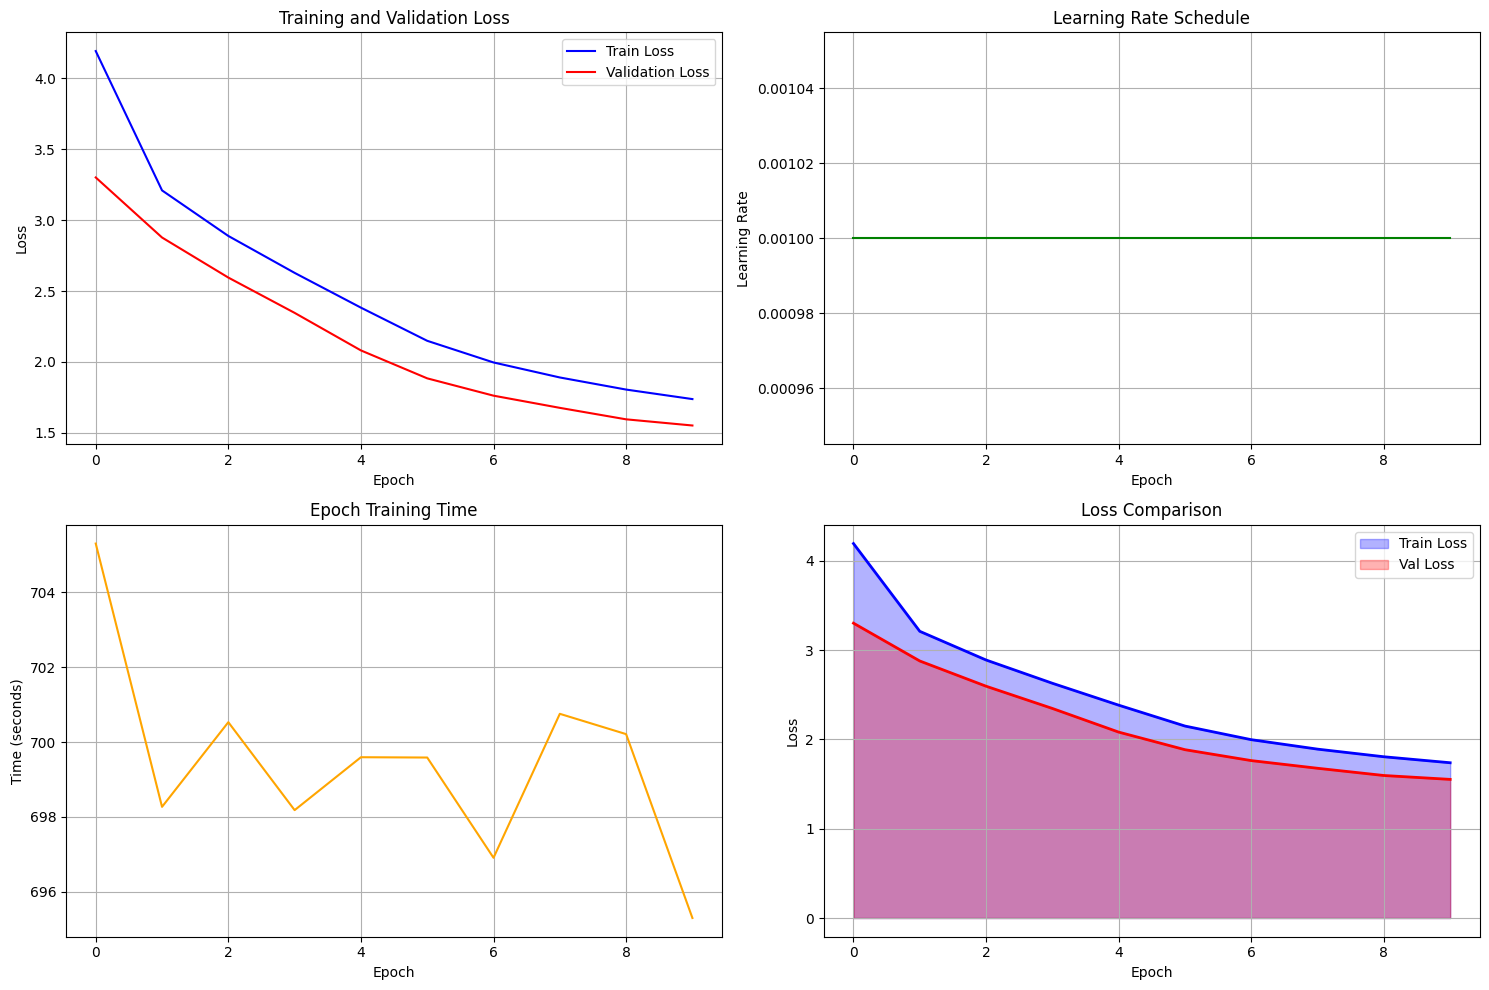

In [4]:
# Train the model with comprehensive training loop

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Trainer:
    """
    Trainer class for Seq2Seq machine translation model
    """
    def __init__(self, model, train_dataloader, val_dataloader, device, 
                 learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        
        # Loss function - ignore padding tokens (index 0)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')
        
        # Optimizer
        self.optimizer = optim.Adam(model.parameters(), 
                                  lr=learning_rate, 
                                  weight_decay=weight_decay)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2
        )
        
        # Training history
        self.history = defaultdict(list)
        
    def calculate_loss(self, outputs, targets, target_lengths=None):
        """Calculate loss for the batch"""
        # Reshape for loss calculation (use reshape instead of view for non-contiguous tensors)
        outputs_flat = outputs.reshape(-1, outputs.size(-1))
        targets_flat = targets.reshape(-1)
        
        # Calculate loss
        loss = self.criterion(outputs_flat, targets_flat)
        
        return loss
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            source_ids = batch['source_ids'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass with teacher forcing
            decoder_input = target_ids[:, :-1]  # Remove last token
            decoder_targets = target_ids[:, 1:]  # Remove first token (BOS)
            
            outputs = self.model(source_ids, decoder_input)
            
            # Calculate loss
            loss = self.calculate_loss(outputs, decoder_targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update parameters
            self.optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_loss / num_batches:.4f}'
            })
            
            # Memory cleanup
            if batch_idx % 100 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return epoch_loss / num_batches
    
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(self.val_dataloader, desc="Validation", leave=False)
        
        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                source_ids = batch['source_ids'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)
                
                # Forward pass
                decoder_input = target_ids[:, :-1]
                decoder_targets = target_ids[:, 1:]
                
                outputs = self.model(source_ids, decoder_input)
                
                # Calculate loss
                loss = self.calculate_loss(outputs, decoder_targets)
                
                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1
                
                # Update progress bar
                progress_bar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'Avg Val Loss': f'{epoch_loss / num_batches:.4f}'
                })
        
        return epoch_loss / num_batches
    
    def train(self, num_epochs=10, save_path=None):
        """Train the model for specified number of epochs"""
        print(f"=== Starting Training for {num_epochs} Epochs ===")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_dataloader)}")
        print(f"Validation batches: {len(self.val_dataloader)}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print("=" * 60)
        
        best_val_loss = float('inf')
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)
            
            # Train
            train_loss = self.train_epoch()
            
            # Validate
            val_loss = self.validate_epoch()
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time
            
            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch_time'].append(epoch_time)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Epoch Time: {epoch_time:.2f}s")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best validation loss: {best_val_loss:.4f}")
                
                if save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'model_config': model_config
                    }, save_path)
                    print(f"Model saved to {save_path}")
            
            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Training summary
        total_time = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} min)")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {self.history['val_loss'][-1]:.4f}")
        
        return self.history
    
    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot learning rate
        axes[0, 1].plot(self.history['learning_rate'], color='green')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True)
        
        # Plot epoch time
        axes[1, 0].plot(self.history['epoch_time'], color='orange')
        axes[1, 0].set_title('Epoch Training Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True)
        
        # Plot loss comparison
        x = range(len(self.history['train_loss']))
        axes[1, 1].fill_between(x, self.history['train_loss'], alpha=0.3, color='blue', label='Train Loss')
        axes[1, 1].fill_between(x, self.history['val_loss'], alpha=0.3, color='red', label='Val Loss')
        axes[1, 1].plot(self.history['train_loss'], color='blue', linewidth=2)
        axes[1, 1].plot(self.history['val_loss'], color='red', linewidth=2)
        axes[1, 1].set_title('Loss Comparison')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=1e-3,
    weight_decay=1e-5
)

# Start training for 10 epochs
print("Starting training...")
history = trainer.train(num_epochs=10, save_path="best_seq2seq_attention_model.pth")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history()


In [5]:
# Fixed Comprehensive Machine Translation Testing Code for Transformer Model

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
import numpy as np
from collections import Counter
import re
import time
import math

class TransformerTranslationTester:
    """
    Comprehensive tester for the Transformer machine translation model
    """
    def __init__(self, model, device, max_length=100):
        self.model = model
        self.device = device
        self.max_length = max_length
        
        # Load tokenizers
        self.tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")
        
        # Special tokens
        self.bos_token = 101  # [CLS] token used as BOS
        self.eos_token = 102  # [SEP] token used as EOS
        self.pad_token = 0    # [PAD] token
        
        print("=== Transformer Translation Tester Initialized ===")
        print(f"Device: {device}")
        print(f"English tokenizer vocab size: {self.tokenizer_en.vocab_size}")
        print(f"Chinese tokenizer vocab size: {self.tokenizer_zh.vocab_size}")
        print(f"Max sequence length: {max_length}")

    def preprocess_text(self, text):
        """Clean and preprocess input text"""
        # Basic cleaning
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
        return text

    def encode_english(self, text):
        """Encode English text to token IDs"""
        text = self.preprocess_text(text)
        tokens = self.tokenizer_en(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return tokens['input_ids'].to(self.device)

    def decode_chinese(self, token_ids):
        """Decode Chinese token IDs to text"""
        # Remove padding tokens and special tokens
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.cpu().tolist()
        
        # Remove padding (0), BOS (101), and EOS (102) tokens
        cleaned_tokens = []
        for token_id in token_ids:
            if token_id not in [0, 101, 102]:
                cleaned_tokens.append(token_id)
            elif token_id == 102:  # Stop at EOS token
                break
        
        if not cleaned_tokens:
            return "[Empty translation]"
        
        try:
            text = self.tokenizer_zh.decode(cleaned_tokens, skip_special_tokens=True)
            # Clean up extra spaces for Chinese
            text = re.sub(r'\s+', '', text)  # Remove all spaces for Chinese
            return text if text else "[Empty translation]"
        except Exception as e:
            return f"[Decoding error: {str(e)}]"

    def translate_single(self, english_text, use_beam_search=False, beam_size=3, temperature=1.0):
        """
        Translate a single English sentence to Chinese
        
        Args:
            english_text: Input English text
            use_beam_search: Whether to use beam search (simplified implementation)
            beam_size: Beam search size (only used if use_beam_search=True)
            temperature: Sampling temperature for generation
        """
        self.model.eval()
        
        with torch.no_grad():
            # Encode input
            source_ids = self.encode_english(english_text)
            
            if not use_beam_search:
                # Use the model's built-in greedy generation
                generated = self.model.generate(
                    source_ids, 
                    max_length=self.max_length,
                    bos_token=self.bos_token,
                    eos_token=self.eos_token,
                    pad_token=self.pad_token
                )
                translation = self.decode_chinese(generated[0])
            else:
                # Use simplified beam search
                translation = self._beam_search_translate(source_ids, beam_size, temperature)
        
        return translation

    def _beam_search_translate(self, source_ids, beam_size=3, temperature=1.0):
        """
        Simplified beam search implementation for Transformer model
        """
        batch_size = source_ids.size(0)
        device = source_ids.device
        
        # Encode source
        src_mask = self.model.create_padding_mask(source_ids)
        encoder_output = self.model.encode(source_ids, src_mask)
        
        # Initialize beams: (sequence, score)
        beams = [(torch.tensor([[self.bos_token]], device=device), 0.0)]
        
        for step in range(self.max_length):
            new_beams = []
            
            for seq, score in beams:
                # If sequence already ended, keep it
                if seq[0, -1].item() == self.eos_token:
                    new_beams.append((seq, score))
                    continue
                
                # Create masks for current sequence
                tgt_mask = self.model.create_padding_mask(seq) & \
                          self.model.create_look_ahead_mask(seq.size(1)).to(device)
                
                # Get decoder output
                decoder_output = self.model.decode(seq, encoder_output, tgt_mask, src_mask)
                
                # Get next token probabilities
                logits = self.model.output_projection(decoder_output[:, -1, :])
                
                # Apply temperature
                if temperature != 1.0:
                    logits = logits / temperature
                
                # Get probabilities
                probs = F.softmax(logits, dim=-1)
                
                # Get top k candidates
                top_probs, top_indices = torch.topk(probs, min(beam_size, probs.size(-1)))
                
                for i in range(top_probs.size(1)):
                    token_id = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                    token_prob = top_probs[0, i].item()
                    new_seq = torch.cat([seq, token_id], dim=1)
                    new_score = score + math.log(token_prob + 1e-10)
                    new_beams.append((new_seq, new_score))
            
            # Keep only top beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
            
            # Check if all beams ended
            if all(seq[0, -1].item() == self.eos_token for seq, _ in beams):
                break
        
        # Return best beam
        best_seq = beams[0][0]
        return self.decode_chinese(best_seq[0])

    def calculate_bleu_score(self, reference, candidate):
        """
        Calculate BLEU score (simplified version)
        """
        def get_ngrams(tokens, n):
            return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
        
        # Tokenize (character-level for Chinese)
        ref_tokens = list(reference.replace(' ', ''))
        cand_tokens = list(candidate.replace(' ', ''))
        
        if len(cand_tokens) == 0:
            return 0.0
        
        # Calculate precision for n-grams (1 to 4)
        precisions = []
        for n in range(1, 5):
            ref_ngrams = Counter(get_ngrams(ref_tokens, n))
            cand_ngrams = Counter(get_ngrams(cand_tokens, n))
            
            if len(cand_ngrams) == 0:
                precisions.append(0.0)
                continue
            
            matches = sum((ref_ngrams & cand_ngrams).values())
            precision = matches / len(get_ngrams(cand_tokens, n))
            precisions.append(precision)
        
        # Calculate brevity penalty
        ref_len = len(ref_tokens)
        cand_len = len(cand_tokens)
        
        if cand_len > ref_len:
            bp = 1.0
        else:
            bp = math.exp(1 - ref_len / (cand_len + 1e-10))
        
        # Calculate BLEU score
        if min(precisions) == 0:
            return 0.0
        
        bleu = bp * math.exp(sum(math.log(p + 1e-10) for p in precisions) / 4)
        return bleu

    def test_examples(self, test_cases, use_beam_search=False, beam_size=3, temperature=1.0):
        """
        Test the model on multiple examples
        """
        print("\n" + "="*80)
        print("MACHINE TRANSLATION TESTING RESULTS")
        print("="*80)
        print(f"Model: Transformer (Attention is All You Need)")
        print(f"Decoding: {'Beam Search' if use_beam_search else 'Greedy'}")
        if use_beam_search:
            print(f"Beam size: {beam_size}")
            print(f"Temperature: {temperature}")
        print("-"*80)
        
        results = []
        total_time = 0
        
        for i, (english, expected_chinese) in enumerate(test_cases, 1):
            print(f"\nTest {i}/{len(test_cases)}")
            print("-" * 40)
            print(f"English:  {english}")
            
            # Translate
            start_time = time.time()
            translation = self.translate_single(english, use_beam_search, beam_size, temperature)
            translation_time = time.time() - start_time
            total_time += translation_time
            
            print(f"Expected: {expected_chinese}")
            print(f"Generated: {translation}")
            print(f"Time: {translation_time:.3f}s")
            
            # Calculate BLEU score if reference is provided
            if expected_chinese and expected_chinese != "":
                bleu_score = self.calculate_bleu_score(expected_chinese, translation)
                print(f"BLEU Score: {bleu_score:.4f}")
            else:
                bleu_score = None
                print("BLEU Score: N/A (no reference)")
            
            results.append({
                'english': english,
                'expected': expected_chinese,
                'translation': translation,
                'time': translation_time,
                'bleu': bleu_score
            })
        
        # Summary statistics
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        print(f"Total examples: {len(test_cases)}")
        print(f"Total time: {total_time:.3f}s")
        print(f"Average time per translation: {total_time/len(test_cases):.3f}s")
        
        bleu_scores = [r['bleu'] for r in results if r['bleu'] is not None]
        if bleu_scores:
            print(f"Average BLEU score: {np.mean(bleu_scores):.4f}")
            print(f"Max BLEU score: {max(bleu_scores):.4f}")
            print(f"Min BLEU score: {min(bleu_scores):.4f}")
        
        return results

    def interactive_translation(self):
        """Interactive translation mode"""
        print("\n" + "="*60)
        print("INTERACTIVE TRANSLATION MODE")
        print("="*60)
        print("Enter English text to translate (type 'quit' to exit)")
        print("Type 'beam' to toggle beam search mode")
        print("-"*60)
        
        use_beam_search = False
        
        while True:
            try:
                user_input = input(f"\nEnglish ({'Beam' if use_beam_search else 'Greedy'}): ").strip()
                
                if user_input.lower() in ['quit', 'exit', 'q']:
                    print("Goodbye!")
                    break
                
                if user_input.lower() == 'beam':
                    use_beam_search = not use_beam_search
                    print(f"Switched to {'Beam Search' if use_beam_search else 'Greedy'} mode")
                    continue
                
                if not user_input:
                    print("Please enter some text.")
                    continue
                
                # Translate
                start_time = time.time()
                translation = self.translate_single(user_input, use_beam_search=use_beam_search)
                translation_time = time.time() - start_time
                
                print(f"Chinese:  {translation}")
                print(f"Time: {translation_time:.3f}s")
                
            except KeyboardInterrupt:
                print("\nGoodbye!")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

# Test cases for English to Chinese translation
TRANSFORMER_TEST_CASES = [
    # Basic greetings and common phrases
    ("Hello", "你好"),
    ("Good morning", "早上好"),
    ("Thank you", "谢谢"),
    ("Nice to meet you", "很高兴见到你"),
    ("Goodbye", "再见"),
    
    # Simple sentences
    ("I love you", "我爱你"),
    ("What is your name?", "你叫什么名字？"),
    ("Where are you from?", "你来自哪里？"),
    ("How are you?", "你好吗？"),
    ("Can you help me?", "你能帮助我吗？"),
    
    # Daily life
    ("I am hungry", "我饿了"),
    ("The weather is nice", "天气很好"),
    ("I need to go to work", "我需要去工作"),
    ("Let's have dinner", "我们吃晚饭吧"),
    ("I am learning Chinese", "我在学中文"),
    
    # Without reference translations (for testing only)
    ("Machine learning is important", ""),
    ("I like to read books", ""),
    ("The cat is sleeping", ""),
    ("Tomorrow is Monday", ""),
    ("Coffee tastes good", ""),
]

# Initialize the corrected tester
print("Initializing Transformer translation tester...")
transformer_tester = TransformerTranslationTester(model, device, max_length=100)

# Check if model was trained
has_trained_model = 'history' in globals() and history is not None
if not has_trained_model:
    print("\n" + "="*80)
    print("WARNING: Model appears to be untrained!")
    print("="*80)
    print("The model has not been trained yet, so translations will be random.")
    print("To get meaningful results, you should train the model first.")
    print("You can still test the translation pipeline, but expect poor quality.")
    print("="*80)

# Test with simple examples first (Greedy decoding)
print("\n" + "="*80)
print("TESTING SIMPLE EXAMPLES (Greedy Decoding)")
print("="*80)
simple_results = transformer_tester.test_examples(TRANSFORMER_TEST_CASES[:3], use_beam_search=False)

# Test one example with beam search
print("\n" + "="*80)
print("TESTING WITH BEAM SEARCH")
print("="*80)
beam_results = transformer_tester.test_examples(TRANSFORMER_TEST_CASES[3:4], use_beam_search=True, beam_size=3, temperature=0.8)

# Quick performance test
print("\n" + "="*80)
print("QUICK PERFORMANCE TEST")
print("="*80)

test_sentences = [
    "Hello",
    "I am happy",
    "The weather is nice today"
]

print("Testing translation speed:")
print("-" * 40)

for i, sentence in enumerate(test_sentences, 1):
    start_time = time.time()
    translation = transformer_tester.translate_single(sentence)
    end_time = time.time()
    
    print(f"Test {i}: {end_time - start_time:.3f}s")
    print(f"  Input:  {sentence}")
    print(f"  Output: {translation}")
    print()

print("="*80)
print("TRANSFORMER TESTING COMPLETE")
print("="*80)
print("You can now use:")
print("- transformer_tester.translate_single('your text here')")
print("- transformer_tester.interactive_translation()")
print("- transformer_tester.test_examples(your_test_cases)")
print("="*80)

Initializing Transformer translation tester...
=== Transformer Translation Tester Initialized ===
Device: cuda
English tokenizer vocab size: 30522
Chinese tokenizer vocab size: 21128
Max sequence length: 100

TESTING SIMPLE EXAMPLES (Greedy Decoding)

MACHINE TRANSLATION TESTING RESULTS
Model: Transformer (Attention is All You Need)
Decoding: Greedy
--------------------------------------------------------------------------------

Test 1/3
----------------------------------------
English:  Hello
Expected: 你好
Generated: 喂.
Time: 0.017s
BLEU Score: 0.0000

Test 2/3
----------------------------------------
English:  Good morning
Expected: 早上好
Generated: 上午好好
Time: 0.012s
BLEU Score: 0.0000

Test 3/3
----------------------------------------
English:  Thank you
Expected: 谢谢
Generated: 谢谢大家
Time: 0.009s
BLEU Score: 0.0000

SUMMARY STATISTICS
Total examples: 3
Total time: 0.038s
Average time per translation: 0.013s
Average BLEU score: 0.0000
Max BLEU score: 0.0000
Min BLEU score: 0.0000

TESTI

# Test Result after 16 epochs of training
![test result](transformer-test-round2.png)